In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/turkcehaber/data.csv
/kaggle/input/trstopwordsss/tr_stop_word.txt


In [2]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
import re

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# **Text Preprocessing**

In [4]:
df=df = pd.read_csv("/kaggle/input/turkcehaber/data.csv")
df.head()

,Haber Gövdesi,Sınıf
0,"Para, şöhret, hepsi var! Peki neden boşanıyorl...",Magazin
1,"Sosyetik güzel Eda Taşpınar, önceki gün Taraby...",Magazin
2,"Suudi Arabistan, İsrail ablukası altındaki Gaz...",Siyaset
3,"MHP Lideri Devlet Bahçeli'den ""Selahattin Demi...",Siyaset
4,"Sıla koronavirüse yakalandı, konserleri ertele...",Magazin


In [5]:
dff=df.copy()

In [6]:
dff.rename(columns={'Haber Gövdesi': 'haber', 'Sınıf': 'sinif'}, inplace=True)

In [7]:
dff.head()

,haber,sinif
0,"Para, şöhret, hepsi var! Peki neden boşanıyorl...",Magazin
1,"Sosyetik güzel Eda Taşpınar, önceki gün Taraby...",Magazin
2,"Suudi Arabistan, İsrail ablukası altındaki Gaz...",Siyaset
3,"MHP Lideri Devlet Bahçeli'den ""Selahattin Demi...",Siyaset
4,"Sıla koronavirüse yakalandı, konserleri ertele...",Magazin


In [8]:
dff.describe(include='all')

,haber,sinif
count,1486009,1486009
unique,1486009,9
top,Siloa Yazıtı'na ilişkin çıkan haberler gerçeği...,Magazin
freq,1,489951


In [9]:
dff.haber.duplicated(keep="first").value_counts()

haber
False    1486009
Name: count, dtype: int64

In [10]:
dff.drop_duplicates(subset="haber",keep="first",inplace=True,ignore_index=True)

In [11]:
dff.describe()

,haber,sinif
count,1486009,1486009
unique,1486009,9
top,Siloa Yazıtı'na ilişkin çıkan haberler gerçeği...,Magazin
freq,1,489951


In [12]:
dff.sinif.unique()

array(['Magazin', 'Siyaset', 'Sağlık', 'Spor', 'Turizm', 'Kültür-Sanat',
       'Finans-Ekonomi', 'Bilim-Teknoloji', 'Çevre'], dtype=object)

In [13]:
dff["sinif"].value_counts()

sinif
Magazin            489951
Siyaset            305452
Spor               230427
Sağlık             122075
Kültür-Sanat       100019
Turizm              71182
Bilim-Teknoloji     68257
Finans-Ekonomi      65414
Çevre               33232
Name: count, dtype: int64

news_dict={'Magazin':0,'Siyaset':1,'Sağlık':2,'Spor':3,'Kültür-Sanat':4,'Turizm':5,'Finans-Ekonomi':6,'Bilim-Teknoloji':7,'Çevre':8}
dff["sinif"]=dff["sinif"].map(news_dict)

# **Analyze Texts**

In [14]:
dff['words'] = [len(x.split()) for x in dff['haber'].tolist()]

In [15]:
dff

,haber,sinif,words
0,"Para, şöhret, hepsi var! Peki neden boşanıyorl...",Magazin,432
1,"Sosyetik güzel Eda Taşpınar, önceki gün Taraby...",Magazin,131
2,"Suudi Arabistan, İsrail ablukası altındaki Gaz...",Siyaset,122
3,"MHP Lideri Devlet Bahçeli'den ""Selahattin Demi...",Siyaset,131
4,"Sıla koronavirüse yakalandı, konserleri ertele...",Magazin,114
...,...,...,...
1486004,Oyuncu Birkan Sokullu Arnavutköy’de görüntül...,Magazin,10
1486005,Türkiye Cumhuriyet Merkez Bankası’nın 200 baz ...,Siyaset,172
1486006,Apple bu yılın sonuna doğru üç adet yeni akıll...,Bilim-Teknoloji,661
1486007,\n\n\n\n\nSüper Lig’in 18. haftasında Kasımpa...,Spor,214


In [16]:
dff['words'].describe()

count   1486009.00
mean        198.64
std         214.68
min           0.00
25%         103.00
50%         137.00
75%         214.00
max        5450.00
Name: words, dtype: float64

In [17]:
dff = dff[~(dff["words"] == 0)]

In [18]:
dff['words'].describe()

count   1486000.00
mean        198.64
std         214.68
min           1.00
25%         103.00
50%         137.00
75%         214.00
max        5450.00
Name: words, dtype: float64

In [19]:
dff.groupby(['sinif'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
sinif,,,,,,,,
Bilim-Teknoloji,68257.00,361.67,288.13,1.00,197.00,271.00,433.00,5450.00
Finans-Ekonomi,65414.00,398.57,369.44,1.00,131.00,153.00,635.00,4540.00
Kültür-Sanat,100019.00,231.33,255.46,1.00,138.00,153.00,210.00,5051.00
Magazin,489951.00,142.88,156.26,1.00,58.00,103.00,171.00,4587.00
Sağlık,122075.00,321.19,193.89,1.00,163.00,282.00,421.00,3145.00
Siyaset,305450.00,140.97,112.04,1.00,125.00,133.00,141.00,4325.00
Spor,230423.00,229.60,255.64,1.00,114.00,173.00,272.00,4726.00
Turizm,71179.00,153.28,153.31,1.00,106.00,127.00,138.00,4499.00
Çevre,33232.00,156.48,165.50,1.00,117.00,130.00,140.00,3709.00


In [20]:
min_word_size = 100
max_word_size = 1500
print(dff["sinif"][dff['words'] < min_word_size].value_counts())
print(dff["sinif"][dff['words'] > max_word_size].value_counts())

sinif
Magazin            235970
Spor                43307
Siyaset             31971
Turizm              16313
Finans-Ekonomi       8518
Çevre                7680
Kültür-Sanat         6478
Sağlık               3475
Bilim-Teknoloji      1464
Name: count, dtype: int64
sinif
Kültür-Sanat       837
Spor               637
Magazin            626
Bilim-Teknoloji    605
Finans-Ekonomi     573
Siyaset            315
Sağlık             116
Turizm              82
Çevre               36
Name: count, dtype: int64


In [21]:
dff= dff[dff['words']>=min_word_size]
dff= dff[dff['words']<=max_word_size]

In [22]:
dff.groupby(['sinif'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
sinif,,,,,,,,
Bilim-Teknoloji,66188.00,352.27,227.41,100.00,201.00,273.00,432.00,1500.00
Finans-Ekonomi,56323.00,436.53,333.28,100.00,138.00,401.00,668.00,1500.00
Kültür-Sanat,92704.00,225.82,180.52,100.00,140.00,156.00,216.00,1500.00
Magazin,253355.00,218.32,157.89,100.00,127.00,167.00,245.00,1500.00
Sağlık,118484.00,327.47,185.63,100.00,172.00,289.00,425.00,1498.00
Siyaset,273164.00,148.67,86.10,100.00,128.00,134.00,143.00,1497.00
Spor,186479.00,255.67,163.81,100.00,146.00,201.00,301.00,1478.00
Turizm,54784.00,180.16,138.75,100.00,124.00,131.00,146.00,1486.00
Çevre,25516.00,190.20,153.50,100.00,128.00,134.00,147.00,1498.00


In [23]:
dff["sinif"].value_counts()

sinif
Siyaset            273164
Magazin            253355
Spor               186479
Sağlık             118484
Kültür-Sanat        92704
Bilim-Teknoloji     66188
Finans-Ekonomi      56323
Turizm              54784
Çevre               25516
Name: count, dtype: int64

In [24]:
df_new= dff[(dff['sinif'] == "Siyaset") & (dff['words'] > 150)]

In [25]:
dff = dff.drop(df_new.index)

In [26]:
df_new = dff[(dff['sinif'] == "Magazin") & (dff['words'] > 200)]

In [27]:
dff = dff.drop(df_new.index)

In [28]:
df_new = dff[(dff['sinif'] == "Spor") & (dff['words'] > 200)]

In [29]:
dff = dff.drop(df_new.index)

In [30]:
df_new = dff[(dff['sinif'] == "Sağlık") & (dff['words'] > 300)]

In [31]:
dff = dff.drop(df_new.index)

In [32]:
df_new=dff[(dff['sinif'] == "Bilim-Teknoloji") & (dff['words'] < 170)]

In [33]:
dff = dff.drop(df_new.index)

In [34]:
df_new = dff[(dff['sinif'] == "Kültür-Sanat") & ((dff['words'] < 120) | (dff['words'] > 220))]

In [35]:
dff = dff.drop(df_new.index)

In [36]:
dff["sinif"].value_counts()

sinif
Siyaset            235590
Magazin            161063
Spor                92600
Kültür-Sanat        66906
Sağlık              62193
Bilim-Teknoloji     57031
Finans-Ekonomi      56323
Turizm              54784
Çevre               25516
Name: count, dtype: int64

In [37]:
dff.groupby(['sinif'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
sinif,,,,,,,,
Bilim-Teknoloji,57031.00,385.77,227.72,170.00,227.00,302.00,470.00,1500.00
Finans-Ekonomi,56323.00,436.53,333.28,100.00,138.00,401.00,668.00,1500.00
Kültür-Sanat,66906.00,154.74,22.66,120.00,138.00,148.00,166.00,220.00
Magazin,161063.00,140.34,28.09,100.00,116.00,136.00,162.00,200.00
Sağlık,62193.00,191.26,55.06,100.00,143.00,178.00,239.00,300.00
Siyaset,235590.00,132.34,8.92,100.00,127.00,132.00,139.00,150.00
Spor,92600.00,146.95,28.17,100.00,123.00,146.00,170.00,200.00
Turizm,54784.00,180.16,138.75,100.00,124.00,131.00,146.00,1486.00
Çevre,25516.00,190.20,153.50,100.00,128.00,134.00,147.00,1498.00


In [38]:
target_classes = ['Siyaset', 'Magazin', 'Spor','Kültür-Sanat','Sağlık','Bilim-Teknoloji','Turizm','Finans-Ekonomi','Çevre']
target_df = dff[dff['sinif'].isin(target_classes)]

# Her bir hedef sınıf için alt örnekleme işlemini gerçekleştirelim
undersampled_df = pd.concat([
    target_df[target_df['sinif'] == 'Siyaset'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    target_df[target_df['sinif'] == 'Magazin'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    target_df[target_df['sinif'] == 'Spor'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    target_df[target_df['sinif'] == 'Kültür-Sanat'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    target_df[target_df['sinif'] == 'Sağlık'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    target_df[target_df['sinif'] == 'Kültür-Sanat'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    target_df[target_df['sinif'] == 'Sağlık'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    target_df[target_df['sinif'] == 'Bilim-Teknoloji'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    target_df[target_df['sinif'] == 'Turizm'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    target_df[target_df['sinif'] == 'Finans-Ekonomi'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    target_df[target_df['sinif'] == 'Çevre'].sample(n=target_df['sinif'].value_counts().min(), replace=False),
    dff[~dff['sinif'].isin(target_classes)]  # Diğer sınıfları olduğu gibi alalım
])

print("\nAlt Örnekleme Sonrası Sınıf Dağılımları:")
print(undersampled_df['sinif'].value_counts())


Alt Örnekleme Sonrası Sınıf Dağılımları:
sinif
Sağlık             51032
Kültür-Sanat       51032
Siyaset            25516
Spor               25516
Magazin            25516
Bilim-Teknoloji    25516
Turizm             25516
Finans-Ekonomi     25516
Çevre              25516
Name: count, dtype: int64


In [39]:
undersampled_df.groupby(['sinif'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
sinif,,,,,,,,
Bilim-Teknoloji,25516.00,387.19,228.06,170.00,228.00,303.00,473.00,1500.00
Finans-Ekonomi,25516.00,436.41,333.95,100.00,138.00,402.00,663.00,1500.00
Kültür-Sanat,51032.00,154.77,22.66,120.00,138.00,148.00,166.00,220.00
Magazin,25516.00,140.22,28.10,100.00,116.00,136.00,162.00,200.00
Sağlık,51032.00,191.67,55.23,100.00,143.00,179.00,239.00,300.00
Siyaset,25516.00,132.31,9.04,100.00,127.00,132.00,139.00,150.00
Spor,25516.00,147.20,28.20,100.00,123.00,146.00,170.00,200.00
Turizm,25516.00,180.41,140.29,100.00,124.00,131.00,146.00,1484.00
Çevre,25516.00,190.20,153.50,100.00,128.00,134.00,147.00,1498.00


In [40]:
undersampled_df

,haber,sinif,words
827772,"Yine iki ay sürmüş olur "" bilgisini paylaştı ...",Siyaset,150
199307,azla olağan iki seçimli dönem üst üste seçileb...,Siyaset,141
553974,mi? Peki yeni bir lider gelecekse yeni lideri ...,Siyaset,130
771976,"i. T24'ten Eray Görülü'nün haberine göre, CHP’...",Siyaset,128
599848,Erdoğan'ın mektubu Rum cephesinde paniğe neden...,Siyaset,145
...,...,...,...
1287988,"man işletme tesisi, 39 tane tersane var. Liman...",Çevre,140
1183632,antral yapımında ısrar eden Türkiye gibi ülkel...,Çevre,128
1311853,"Maden İşçisi, Torba Yasa Tasarısını Protesto E...",Çevre,294
1451827,"Palandöken: ""Karşılıksız Çekler Yüzde 44 Azald...",Çevre,299


In [41]:
def clean_text(text):
    text = text.replace('İ', 'i')
    text = text.lower()
    unwanted_pattern = r"[!.\n,\'“”?@#x*\-+/%&\"':;’]"
    regex = re.compile(unwanted_pattern)
    cleaned_text = regex.sub(" ", text)
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    return cleaned_text

In [42]:
undersampled_df["haber"] = undersampled_df["haber"].apply(clean_text)

In [43]:
undersampled_df

,haber,sinif,words
827772,yine iki ay sürmüş olur bilgisini paylaştı ...,Siyaset,150
199307,azla olağan iki seçimli dönem üst üste seçileb...,Siyaset,141
553974,mi peki yeni bir lider gelecekse yeni lideri ...,Siyaset,130
771976,i t ten eray görülü nün haberine göre chp de...,Siyaset,128
599848,erdoğan ın mektubu rum cephesinde paniğe neden...,Siyaset,145
...,...,...,...
1287988,man işletme tesisi tane tersane var liman b...,Çevre,140
1183632,antral yapımında ısrar eden türkiye gibi ülkel...,Çevre,128
1311853,maden işçisi torba yasa tasarısını protesto e...,Çevre,294
1451827,palandöken karşılıksız çekler yüzde azaldı ...,Çevre,299


In [44]:
word_freq= undersampled_df.haber.str.split(expand=True).stack().value_counts()


In [45]:
word_freq=word_freq.reset_index(name='freq').rename(columns={'index': 'word'})

In [46]:
top_50_frequent_words = word_freq[:50]
top_50_frequent_words

,word,freq
0,ve,1399044
1,bir,979452
2,bu,615737
3,da,517848
4,de,472625
5,için,391997
6,ile,373607
7,olarak,242270
8,daha,215700
9,çok,208282


In [47]:
tr_stop_words = pd.read_csv('/kaggle/input/trstopwordsss/tr_stop_word.txt',header=None)
print("First 5 entries:")
for each in tr_stop_words.values[:5]:
  print(each[0])

First 5 entries:
ama
amma
anca
ancak
bu


In [48]:
for each in top_50_frequent_words['word']:
  if each in tr_stop_words.values:
    print (each)

ve
bir
bu
da
de
için
ile
daha
çok
ise
göre
ın
gibi
kadar
in
nın
a
sonra
ya
dr
oldu
ancak
e


In [49]:
def remove_stopwords(text):
    words = text.split()
    clean_words = [word for word in words if word.lower() not in tr_stop_words.values]
    return ' '.join(clean_words)

In [50]:
undersampled_df["haber"] =undersampled_df["haber"].apply(remove_stopwords)

In [51]:
undersampled_df = undersampled_df.set_index('words')  


In [52]:
undersampled_df

,haber,sinif
words,,
150,iki ay sürmüş bilgisini paylaştı belediye başk...,Siyaset
141,azla olağan iki seçimli dönem üst üste seçileb...,Siyaset
130,mi yeni lider gelecekse yeni lideri önceki lid...,Siyaset
128,i t ten eray görülü haberine chp değişim tartı...,Siyaset
145,erdoğan mektubu rum cephesinde paniğe kıyamet ...,Siyaset
...,...,...
140,man işletme tesisi tane tersane var liman başk...,Çevre
128,antral yapımında ısrar eden türkiye ülkelere d...,Çevre
294,maden işçisi torba yasa tasarısını protesto ed...,Çevre


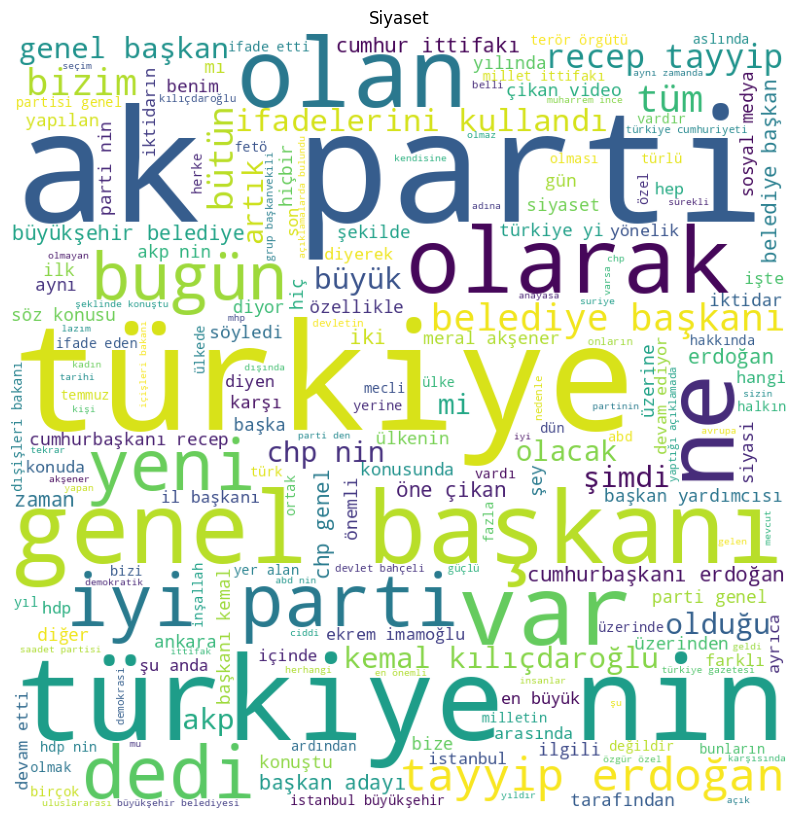

In [53]:
selected_category = "Siyaset"
selected_texts = undersampled_df[undersampled_df['sinif'] == selected_category]['haber']
merged_text = ' '.join(selected_texts)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(merged_text)

plt.figure(figsize=(8, 8), facecolor=None)

plt.imshow(wordcloud)
plt.title('Siyaset')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

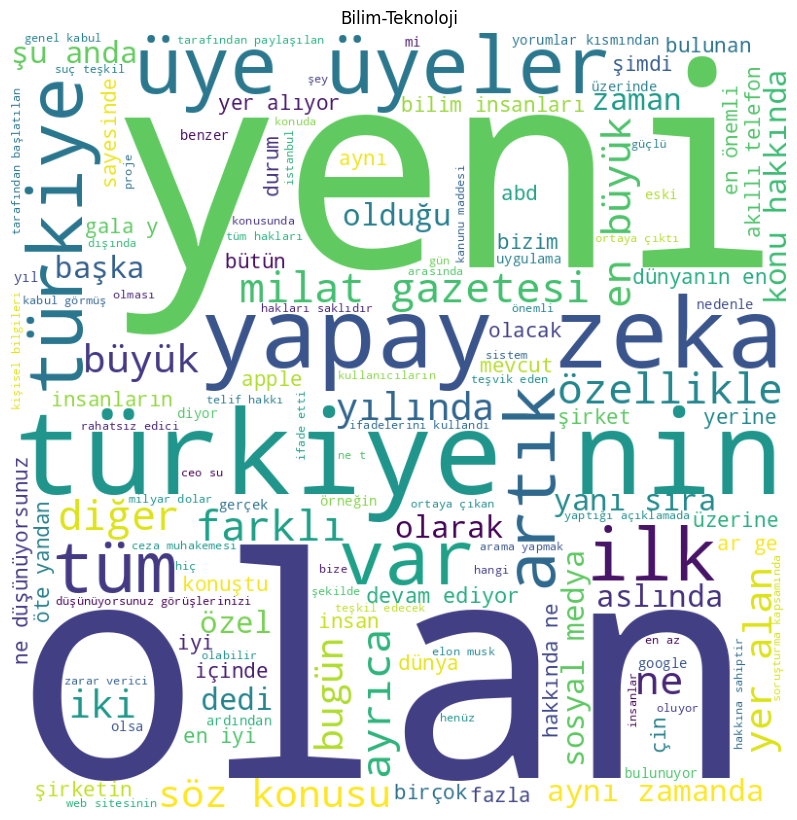

In [54]:
selected_category = "Bilim-Teknoloji"
selected_texts = undersampled_df[undersampled_df['sinif'] == selected_category]['haber']
merged_text = ' '.join(selected_texts)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(merged_text)

plt.figure(figsize=(8, 8), facecolor=None)

plt.imshow(wordcloud)
plt.title('Bilim-Teknoloji')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

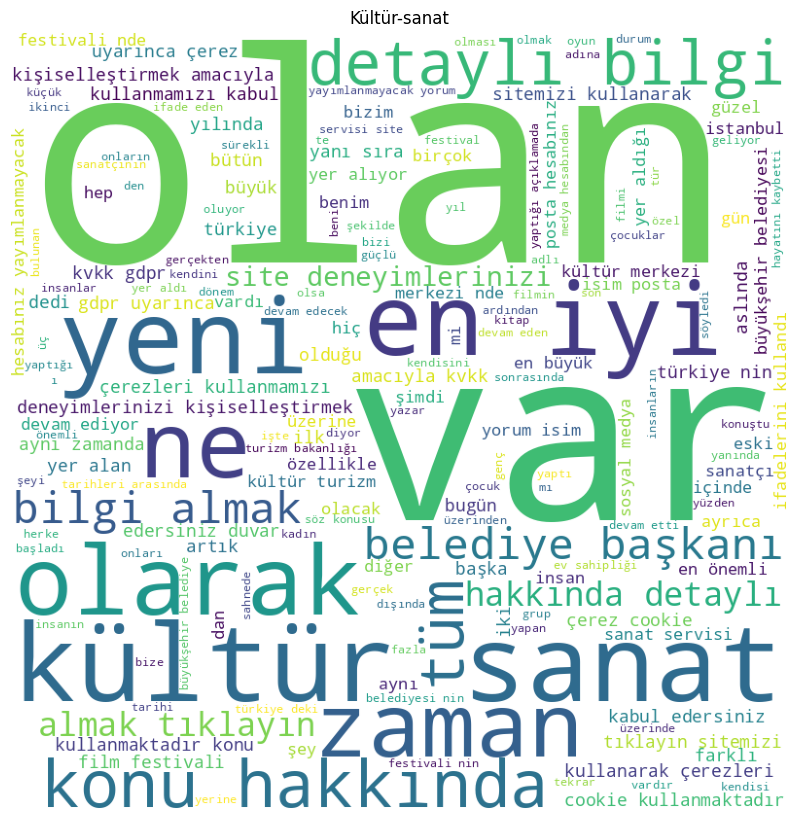

In [55]:
selected_category = "Kültür-Sanat"
selected_texts = undersampled_df[undersampled_df['sinif'] == selected_category]['haber']
merged_text = ' '.join(selected_texts)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(merged_text)

plt.figure(figsize=(8, 8), facecolor=None)

plt.imshow(wordcloud)
plt.title('Kültür-sanat')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

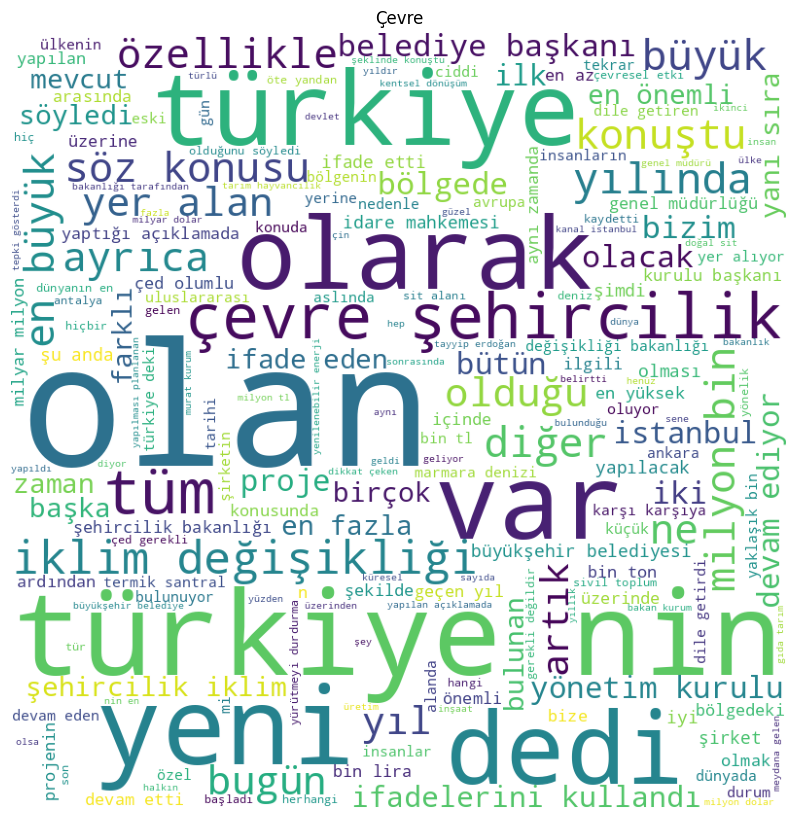

In [56]:
selected_category = "Çevre"
selected_texts = undersampled_df[undersampled_df['sinif'] == selected_category]['haber']
merged_text = ' '.join(selected_texts)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(merged_text)

plt.figure(figsize=(8, 8), facecolor=None)

plt.imshow(wordcloud)
plt.title('Çevre')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

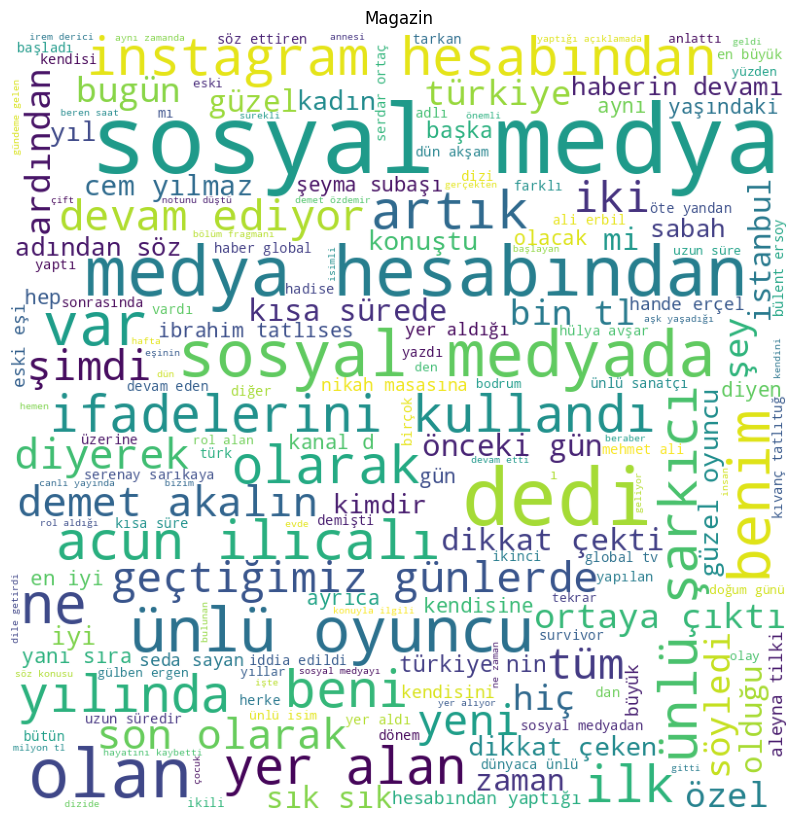

In [57]:
selected_category = "Magazin"
selected_texts = undersampled_df[undersampled_df['sinif'] == selected_category]['haber']
merged_text = ' '.join(selected_texts)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(merged_text)

plt.figure(figsize=(8, 8), facecolor=None)

plt.imshow(wordcloud)
plt.title('Magazin')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [58]:
undersampled_df.to_csv('undersampled_data.csv') 

